In [3]:
import pandas as pd
import numpy as np
import cv2
import requests
import random as rand
import shutil # save query image locally

from PIL import Image, ImageStat
from os.path import exists

In [4]:
def run_query(query):
    response = requests.post('https://api.tarkov.dev/graphql', json={'query': query})
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(response.status_code, query))
        
def load_icons_from_disk(verbose=False):
    global all_items_df
    
    icons = []
    for index,item in all_items_df.iterrows():
        filename = path_grid_icons + item['id'] + filename_ending_grid_icon
        if exists(filename):
            icons.append(np.asarray(Image.open(filename)))
        else:
            icons.append([])
            if verbose:
                print(f"File {filename} does not exist.")
    return icons

def run_sift(img):
    global sift
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    kp,des = sift.detectAndCompute(gray,None)
    return kp,des

def create_all_descriptors():
    global icons
    descriptors = []
    for icon in icons:
        if len(icon) == 0:
            descriptors.append(None)
            continue
        kp,des = run_sift(icon)
        descriptors.append(des)
    return descriptors

def predict_icon(img):
    global icons, bf, descriptors
    distances = []
    
    kp,des = run_sift(img)

    for i in range(len(icons)):
        if descriptors[i] is None:
            distances.append(99999)
            continue

        matches = bf.match(des, descriptors[i])

        distance = 0
        for match in matches:
            distance += match.distance
        distances.append(distance)

    prediction = np.argmin(distances)
    return prediction

In [5]:
# paths
path_icons = './icons/'
path_grid_icons = './grid_icons/'
path_data = './data/'

filename_ending_grid_icon = '-grid-image.jpg'

In [6]:
icons = []
descriptors = []
all_items_df = None

sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

# Download all item icons

In [8]:
get_all_items = """
{
    items {
        id
        gridImageLink
    }
}
"""
query_result = run_query(get_all_items)['data']['items']

# Set up the image URL and filename

# for i in query_result:
#     item_id = i['id']
#     image_url = i['gridImageLink']
#     filename = image_url.split("/")[-1]

#     # Open the url image, set stream to True, this will return the stream content.
#     r = requests.get(image_url, stream = True)

#     # Check if the image was retrieved successfully
#     if r.status_code == 200:
#         # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
#         r.raw.decode_content = True

#         # Open a local file with wb ( write binary ) permission.
#         with open(filename,'wb') as f:
#             shutil.copyfileobj(r.raw, f)

#         print('Image sucessfully Downloaded: ',filename)
#     else:
#         print('Image Couldn\'t be retreived')

# Create SIFT features

In [9]:
# get image data
all_items_df = pd.read_csv(path_data + 'all_items.csv')

In [10]:
# read icons from disk
icons = load_icons_from_disk()

In [11]:
# create descriptors for each icon
descriptors = create_all_descriptors()

In [ ]:
# save descriptors


## check sift features on random item

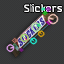

In [12]:
# sift
index = rand.randrange(2500)
Image.fromarray(icons[index])
img = icons[index]
kp,des = run_sift(img)
img_sift = cv2.drawKeypoints(img,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
Image.fromarray(img_sift)


## predict random item

Predicted: 923
True:      923


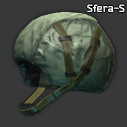

In [15]:
index = rand.randrange(2500)

to_find = icons[index]

prediction = predict_icon(to_find)

print(f"Predicted: {prediction}")
print(f"True:      {index}")

Image.fromarray(to_find)